In [30]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm, trange
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [31]:
# Data from https://www.kaggle.com/mczielinski/bitcoin-historical-data
orig_df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv")

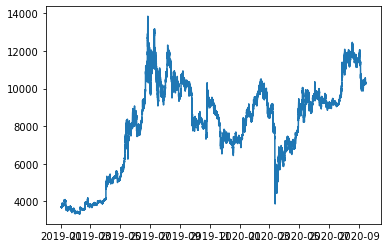

In [32]:
df = orig_df[orig_df['Timestamp'] >= datetime(2019, 1, 1).replace(tzinfo=timezone.utc).timestamp() + 60]
data = df.reset_index(drop=True).fillna(method='ffill')
dates = pd.to_datetime(data['Timestamp'], unit='s')

plt.plot(dates, data['Close'])

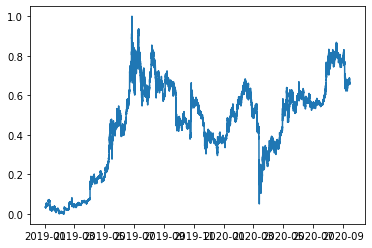

In [33]:
price = data['Close'].to_numpy().reshape(-1, 1)
min_max_scaler = MinMaxScaler()
norm_data = min_max_scaler.fit_transform(price)
plt.plot(dates, norm_data)

In [34]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in trange(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

past_history = 5
future_target = 0
TRAIN_SPLIT = int(len(data) * 0.8)
x_train, y_train = univariate_data(norm_data,
                                   0,
                                   TRAIN_SPLIT,
                                   past_history,
                                   future_target)
x_test, y_test = univariate_data(norm_data,
                                 TRAIN_SPLIT,
                                 None,
                                 past_history,
                                 future_target)

100%|██████████| 179131/179131 [00:01<00:00, 102619.27it/s]


In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='tanh', input_shape=(None, 1)),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=0.0001))
history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.1, callbacks=[early_stopping], shuffle=False)

Epoch 1/100
20153/20153 [==============================] - 24s 1ms/step - loss: 2.6703e-04 - val_loss: 0.0124
Epoch 2/100
20153/20153 [==============================] - 24s 1ms/step - loss: 1.7495e-04 - val_loss: 0.0077
Epoch 3/100
20153/20153 [==============================] - 25s 1ms/step - loss: 1.2622e-04 - val_loss: 0.0034
Epoch 4/100
20153/20153 [==============================] - 25s 1ms/step - loss: 1.1301e-04 - val_loss: 0.0020
Epoch 5/100
20153/20153 [==============================] - 25s 1ms/step - loss: 1.1016e-04 - val_loss: 0.0015
Epoch 6/100
20153/20153 [==============================] - 25s 1ms/step - loss: 1.0996e-04 - val_loss: 0.0013
Epoch 7/100
20153/20153 [==============================] - 25s 1ms/step - loss: 1.0781e-04 - val_loss: 0.0012
Epoch 8/100
20153/20153 [==============================] - 24s 1ms/step - loss: 1.0789e-04 - val_loss: 0.0011
Epoch 9/100
20153/20153 [==============================] - 25s 1ms/step - loss: 1.0686e-04 - val_loss: 0.0010
Epoch 10/1

<Figure size 432x288 with 0 Axes>

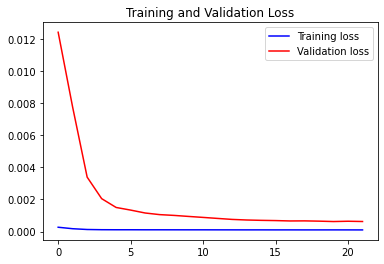

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.clf()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

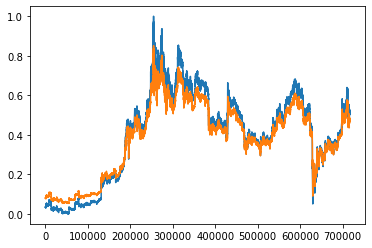

In [37]:
result = model.predict(x_train)
plt.clf()
plt.plot(y_train[5:])
plt.plot(result)

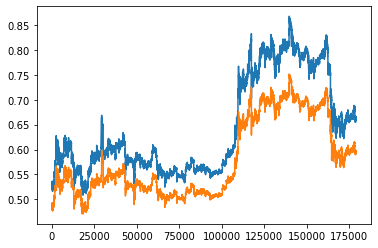

In [39]:
result = model.predict(x_test)
plt.clf()
plt.plot(y_test[5:])
plt.plot(result)